In [142]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [143]:
results = glob.glob("./results/*.json")
ORIGINAL_NUM_PARAMETERS = 134301514

In [162]:
strategies = []
max_accuracy = []
num_params = []
losses = []
retained_parameters = []
for result in results:
    with open(result, 'r') as fp:
        data = json.load(fp)
        if data['did_it_train']:
            strategies.append(data['strategy'])
            max_accuracy.append(max(data['accuracies']))
            num_params.append(data['pruned_num_parameters'])
            retained_parameters.append(100 * data['pruned_num_parameters']/ORIGINAL_NUM_PARAMETERS)
            losses.append(data['losses'])

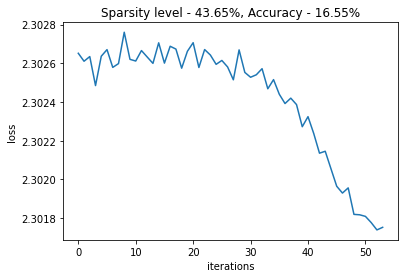

In [181]:
kk = 127
plt.plot(losses[kk])
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title(f"Sparsity level - {100 - round(retained_parameters[kk], 2)}%, Accuracy - {max_accuracy[kk]}%")
plt.show()

In [145]:
min(max_accuracy)

10.0

In [146]:
len(max_accuracy)

262

<AxesSubplot:>

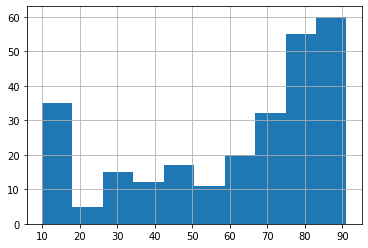

In [147]:
pd.Series(max_accuracy).hist()

<AxesSubplot:>

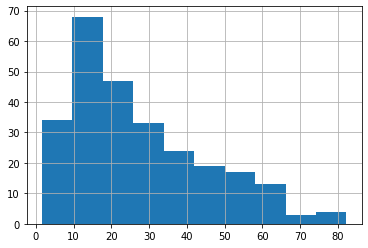

In [148]:
pd.Series(retained_parameters).hist()

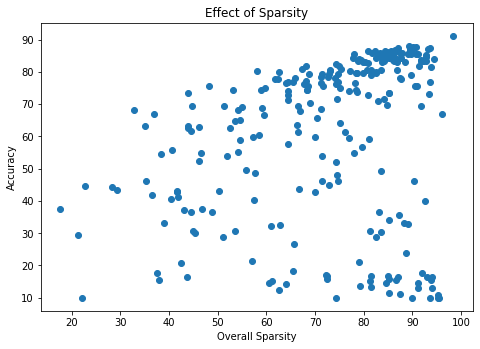

In [149]:
retained_parameters_2 = [100 - x for x in retained_parameters]
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(retained_parameters_2, max_accuracy)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Overall Sparsity')
ax.set_title('Effect of Sparsity')
plt.show()

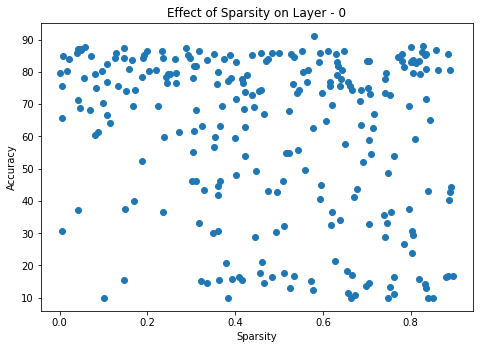

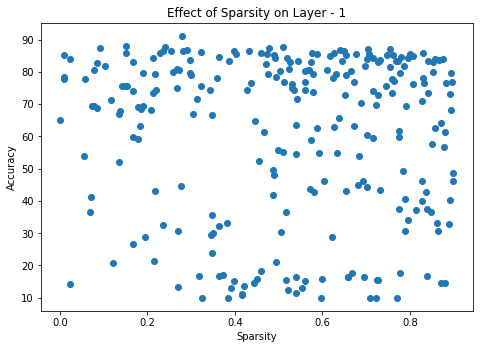

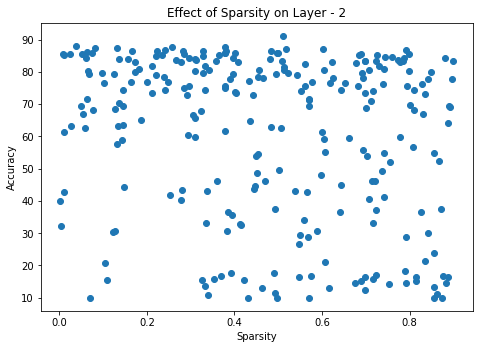

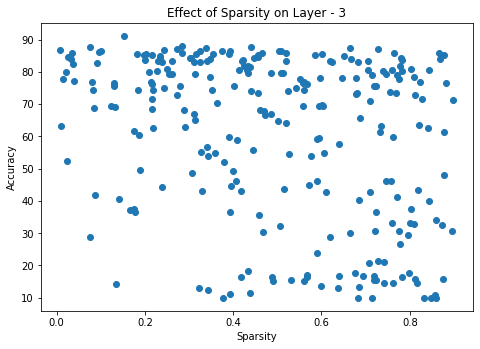

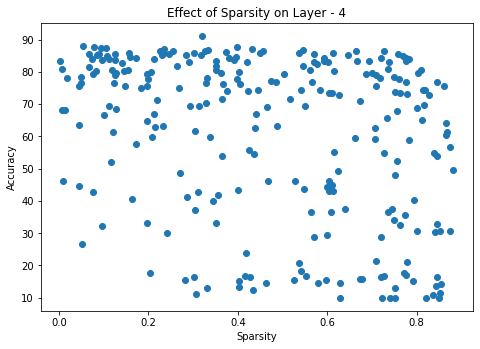

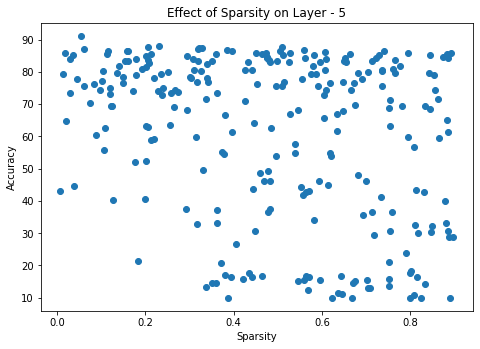

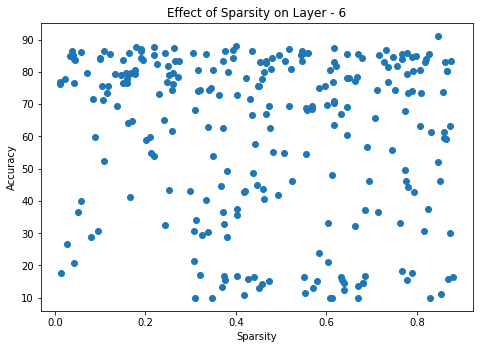

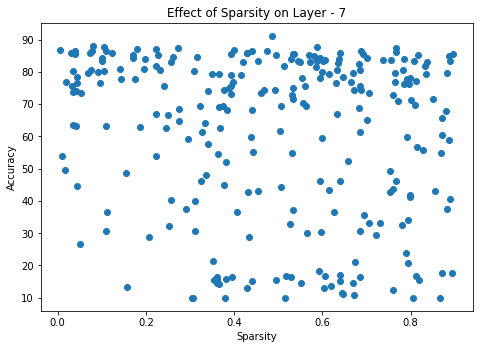

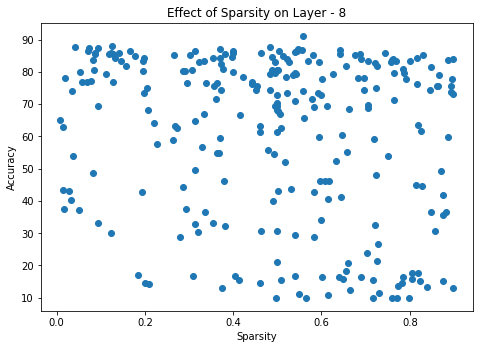

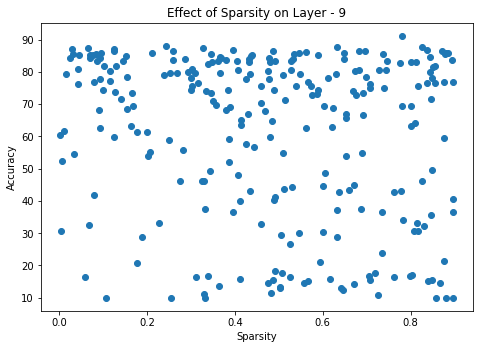

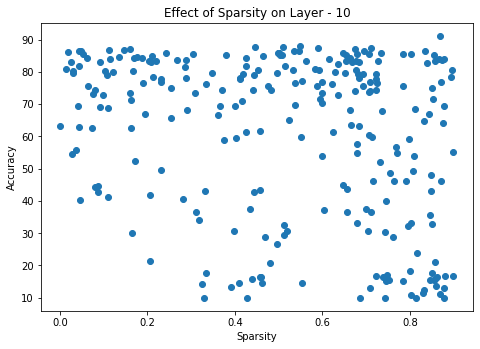

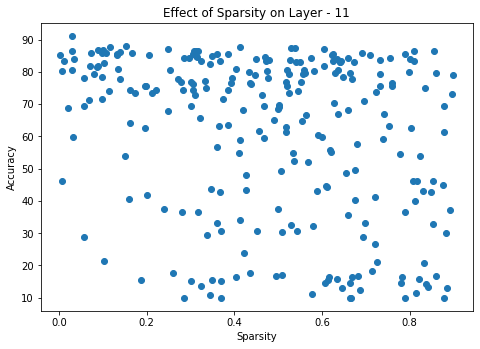

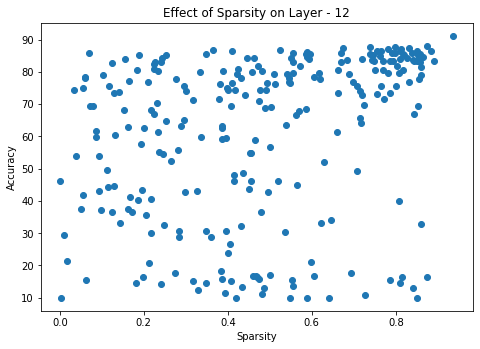

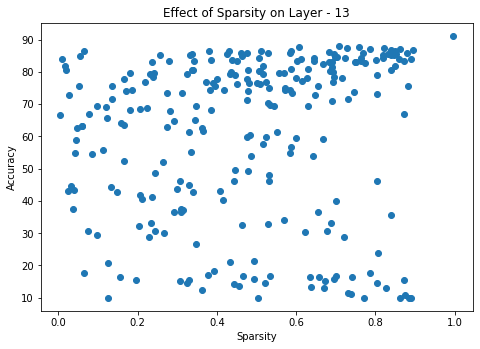

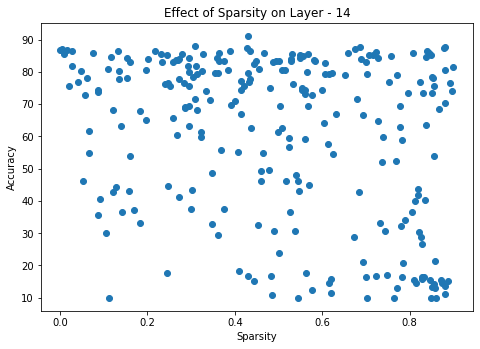

In [150]:
for param_number in range(15):
    strategy_param = [strategy[param_number] for strategy in strategies]
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(strategy_param, max_accuracy)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(f'Sparsity')
    ax.set_title(f'Effect of Sparsity on Layer - {param_number}')
    plt.show()

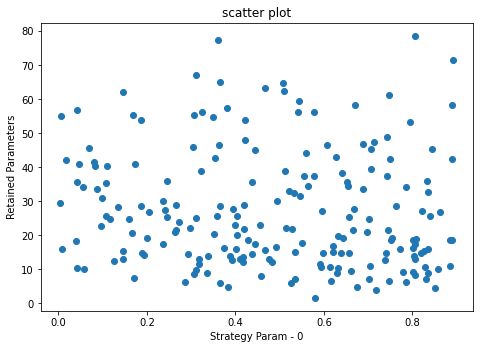

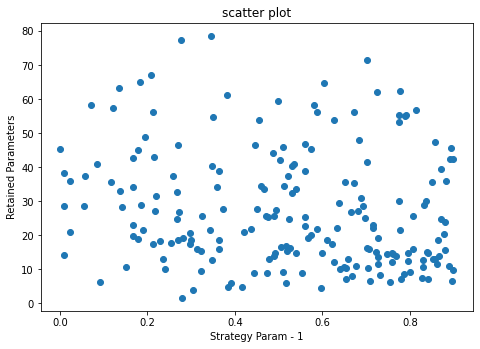

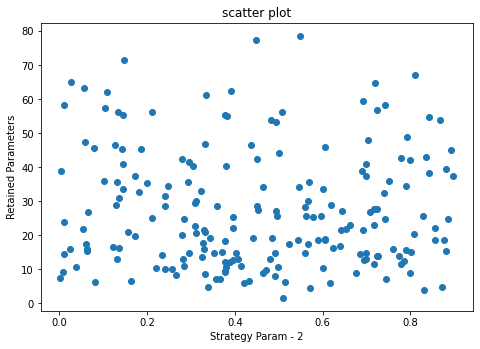

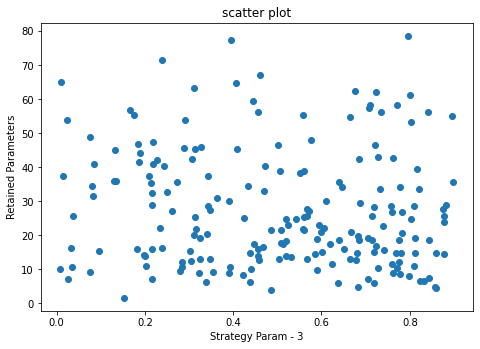

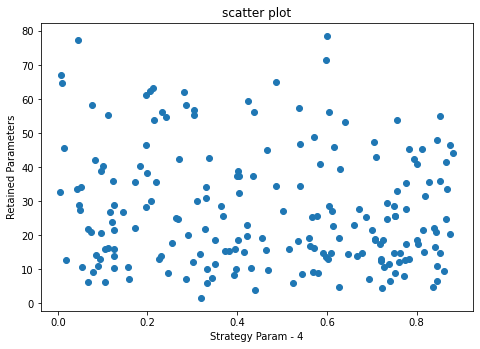

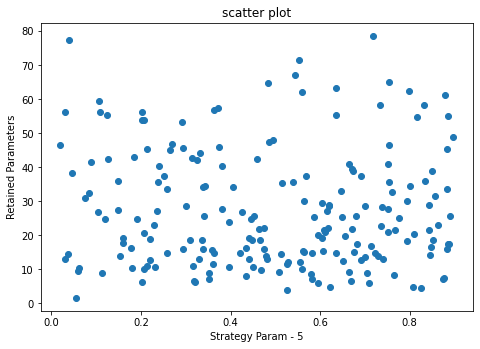

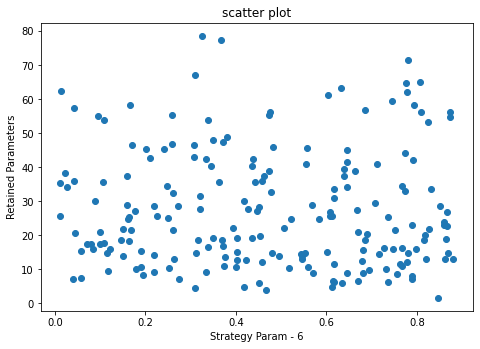

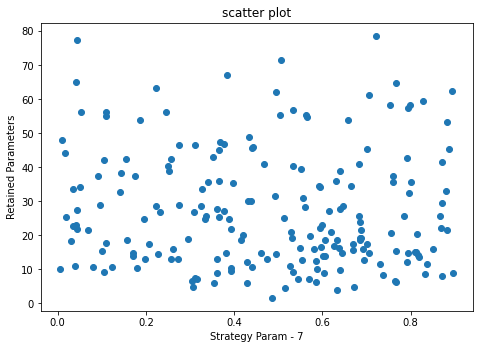

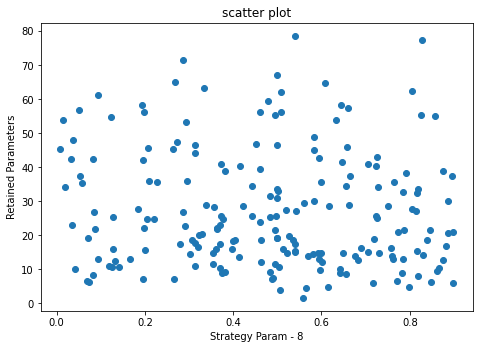

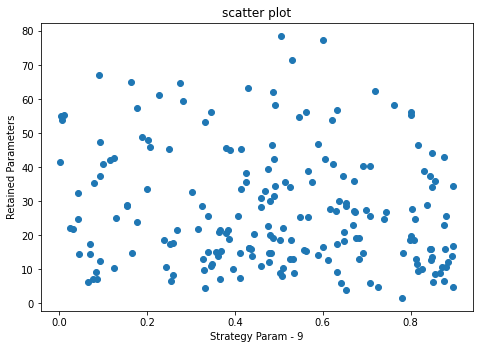

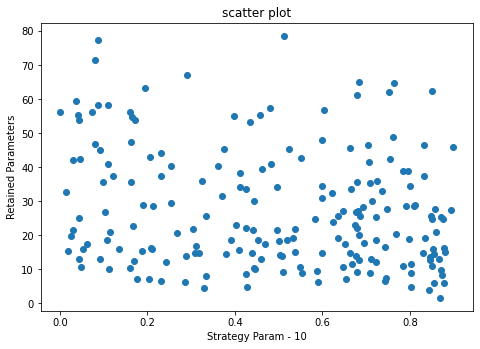

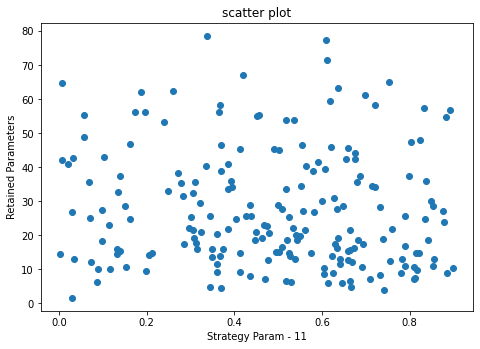

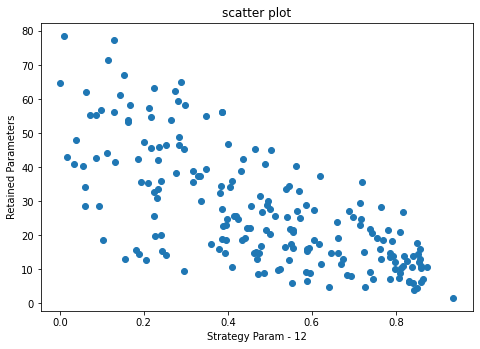

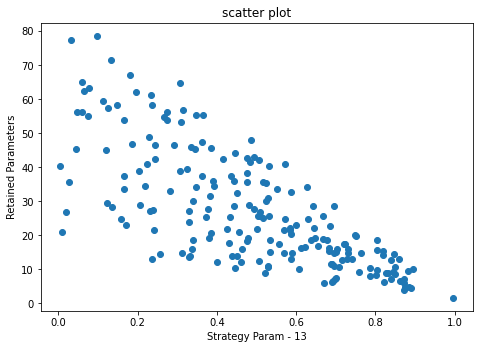

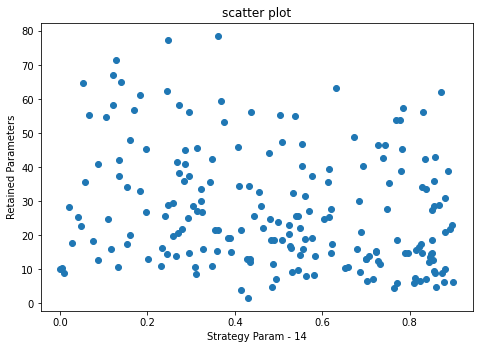

In [33]:
for param_number in range(15):
    strategy_param = [strategy[param_number] for strategy in strategies]
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(strategy_param, retained_parameters)
    ax.set_ylabel('% Retained Parameters')
    ax.set_xlabel(f'Layer - {param_number}')
    ax.set_title('scatter plot')
    plt.show()

In [151]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import trange
from sklearn.model_selection import train_test_split

In [152]:
def build_dataloader(strategies, max_accuracy, retained_parameters):
    strategies_tensor = torch.Tensor(strategies)
    accuracies_tensor = torch.Tensor(max_accuracy)
    num_parameters_tensor = torch.Tensor(retained_parameters)

    dataset = TensorDataset(strategies_tensor, accuracies_tensor, num_parameters_tensor)
    dataloader = DataLoader(dataset, shuffle=True, batch_size=4)
    return dataloader

In [153]:
strategies_train, strategies_test, max_accuracy_train, max_accuracy_test, retained_parameters_train, retained_parameters_test = train_test_split(strategies, max_accuracy, retained_parameters, test_size=0.2, random_state=1337)
train_dataloader = build_dataloader(strategies_train, max_accuracy_train, retained_parameters_train)
test_dataloader = build_dataloader(strategies_test, max_accuracy_test, retained_parameters_test)

In [154]:
class PerformancePredictor(nn.Module):
    def __init__(self, num_hidden_units, dropout_prob=0.1):
        super(PerformancePredictor, self).__init__()
        self.fc1 = nn.Linear(15, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.acc_layer = nn.Linear(num_hidden_units, 1)
        self.num_param_layer = nn.Linear(num_hidden_units, 1)
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x1 = self.acc_layer(x)
        x2 = self.num_param_layer(x)
        return x1, x2

In [155]:
predictor = PerformancePredictor(num_hidden_units=400, dropout_prob=0.1)
criterion = nn.MSELoss()
optimizer = optim.SGD(predictor.parameters(), lr=0.001)
epochs = 200

In [156]:
%%time
x,y = predictor(torch.rand(1, 15))

Wall time: 38 ms


In [157]:
losses = []
for epoch in trange(epochs):
    for data in train_dataloader:
        
        strat, acc, num_param = data
        
#         strat = torch.cat([strat, num_param.unsqueeze(1) / 100], 1)
        
        pred_acc, pred_num_param = predictor(strat)
        
        loss1 = criterion(pred_acc.squeeze(), acc.squeeze())
        loss2 = criterion(pred_num_param.squeeze(), num_param.squeeze())
        
        loss = loss1 
        loss += loss2
        
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [158]:
losses[-10:]

[131.83367919921875,
 170.1549530029297,
 24.666488647460938,
 10.114482879638672,
 27.75518035888672,
 45.174041748046875,
 85.5689468383789,
 43.42329788208008,
 15.895859718322754,
 32.666259765625]

In [159]:
val_losses_acc = []
val_loss_num_param = []
good_results = []
bad_results = []
with torch.no_grad():
    predictor = predictor.eval()
    for data in test_dataloader:
        strat, acc, num_param = data
        
#         strat = torch.cat([strat, num_param.unsqueeze(1) / 100], 1)
        
        pred_acc, pred_num_param = predictor(strat)
        pred_acc = pred_acc.clamp(0, 100)
        pred_num_param = pred_num_param.clamp(0, 100)
#         print(acc.squeeze(), pred_acc.squeeze())
        for i, j, k in zip(acc.squeeze().tolist(), pred_acc.squeeze().tolist(), num_param.squeeze().tolist()):
            if abs(i-j) < 5:
                good_results.append((i, j, (i-j)**2, k))
            else:
                bad_results.append((i, j, (i-j)**2, k))
#         print(num_param.squeeze(), pred_num_param.squeeze())
        loss1 = criterion(pred_acc.squeeze(), acc)
        loss2 = criterion(pred_num_param.squeeze(), num_param)
        val_losses_acc.append(loss1)
        val_loss_num_param.append(loss2)

TypeError: 'float' object is not iterable

In [160]:
for i,j,k,l in good_results:
    print(i, j, l)

87.06999969482422 83.6053466796875 10.50314998626709
76.44999694824219 76.09684753417969 35.95271301269531
79.5 81.24992370605469 21.41797637939453
37.560001373291016 33.685054779052734 53.253421783447266
59.68000030517578 63.81837463378906 42.6644401550293
87.27999877929688 83.7634506225586 12.948782920837402
36.61000061035156 35.14537811279297 55.38438034057617
79.33999633789062 77.70497131347656 28.492521286010742
74.33999633789062 77.9053955078125 31.70672035217285
61.709999084472656 56.890045166015625 55.48053741455078
17.030000686645508 14.01589584350586 27.77825927734375
81.77999877929688 78.53529357910156 31.94184112548828
79.30000305175781 80.83814239501953 27.206336975097656
86.44999694824219 83.45702362060547 19.067346572875977
77.91999816894531 80.95376586914062 25.873823165893555
85.69999694824219 83.7745132446289 16.59686279296875
84.16999816894531 81.00338745117188 12.28641128540039
86.55000305175781 83.3157730102539 17.763940811157227
10.0 12.984631538391113 4.669767379

In [161]:
for i,j,k,l in bad_results:
    print(i, j, l)

83.06999969482422 76.51837158203125 19.722700119018555
40.349998474121094 54.16053771972656 42.43700408935547
12.880000114440918 30.6656494140625 5.919440269470215
10.0 15.383975982666016 25.606796264648438
46.06999969482422 57.86153793334961 9.763572692871094
71.44000244140625 78.6006851196289 15.807750701904297
77.61000061035156 72.03898620605469 37.543418884277344
43.08000183105469 33.887332916259766 58.36879348754883
55.88999938964844 45.828826904296875 59.39442443847656
55.15999984741211 36.024085998535156 45.89472198486328
69.55999755859375 78.36752319335938 15.143269538879395
75.5 59.90237808227539 51.744972229003906
62.560001373291016 52.397789001464844 56.11809158325195
46.040000915527344 19.23859977722168 25.315271377563477
64.83999633789062 51.23983383178711 46.52423095703125
86.44999694824219 79.48394775390625 12.999507904052734
73.81999969482422 65.98385620117188 21.39464569091797
69.22000122070312 57.641075134277344 45.01105499267578
80.45999908447266 72.80024719238281 16

In [135]:
good_results[0]

(74.2699966430664, 76.56698608398438, 5.276160491688643, 31.581342697143555)

In [139]:
val_losses_acc

[tensor(168.5803),
 tensor(56.4582),
 tensor(211.0813),
 tensor(526.8661),
 tensor(769.2881),
 tensor(215.9996),
 tensor(395.8073),
 tensor(117.3822),
 tensor(48.4663),
 tensor(53.8636),
 tensor(24.9797)]

In [140]:
sum(val_losses_acc) / len(val_losses_acc)

tensor(235.3430)

In [137]:
val_loss_num_param

[tensor(15.9483),
 tensor(31.7484),
 tensor(11.7868),
 tensor(3.7850),
 tensor(13.6865),
 tensor(9.9012),
 tensor(5.1300),
 tensor(2.1909),
 tensor(15.5839),
 tensor(11.5454),
 tensor(15.7355)]

In [138]:
sum(val_loss_num_param) / len(val_loss_num_param)

tensor(12.4584)

In [83]:
def black_box_function(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15):
    strat = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15]
    strat = torch.Tensor(strat).unsqueeze(0)
    accuracy, num_parameters = predictor(strat)
    accuracy, num_parameters = accuracy.clamp(0, 100).item(), num_parameters.clamp(0, 100).item()
    return accuracy * num_parameters

In [192]:
from scipy.optimize import differential_evolution

In [197]:
maximum_num_params = 100
min_accuracy = 85

def black_box_function_2(strat):
    strat = torch.Tensor(strat).unsqueeze(0)
    accuracy, num_parameters = predictor(strat)
    accuracy, num_parameters = accuracy.clamp(0, 100).item(), num_parameters.clamp(0, 100).item()
    if accuracy > 90 or num_parameters < 2:
        return 1000
    return -1 * (accuracy - min_accuracy) * (maximum_num_params - num_parameters)

In [198]:
%%time
bounds = [(0, 0.95) for _ in range(15)]
result = differential_evolution(black_box_function_2, bounds)

Wall time: 54.9 s


In [199]:
result

     fun: -489.66447535014595
     jac: array([    0.        ,     0.        ,     0.        ,   119.14926296,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        , 74635.36184119,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 72319
     nit: 318
 success: True
       x: array([0.24289577, 0.47130221, 0.34075939, 0.14445396, 0.31957039,
       0.14157267, 0.5757456 , 0.43728562, 0.10559674, 0.61098339,
       0.52964777, 0.31864761, 0.90467692, 0.94151831, 0.41074057])

In [200]:
strat = result.x
predictor(torch.Tensor(strat).unsqueeze(0))

(tensor([[89.9975]], grad_fn=<AddmmBackward>),
 tensor([[2.0178]], grad_fn=<AddmmBackward>))

In [518]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x1': (0, 0.95), 'x2': (0, 0.95), 'x3': (0, 0.95), 'x4': (0, 0.95), 'x5': (0, 0.95), 'x6': (0, 0.95), 'x7': (0, 0.95), 'x8': (0, 0.95), 'x9': (0, 0.95), 'x10': (0, 0.95), 'x11': (0, 0.95), 'x12': (0, 0.95), 'x13': (0, 0.95), 'x14': (0, 0.95), 'x15': (0, 0.95)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1337,
    verbose=0
)

In [519]:
optimizer.maximize(
    init_points=100,
    n_iter=300,
)

|   iter    |  target   |    x1     |    x10    |    x11    |    x12    |    x13    |    x14    |    x15    |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |    x9     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  2.648e+0 |  0.2489   |  0.1507   |  0.2642   |  0.4364   |  0.305    |  0.4925   |  0.2488   |  0.9273   |  0.6962   |  0.1095   |  0.367    |  0.5971   |  0.1188   |  0.9344   |  0.4211   |
|  2        |  1.357e+0 |  0.7501   |  0.7544   |  0.3432   |  0.3953   |  0.555    |  0.7222   |  0.1784   |  0.2738   |  0.6367   |  0.4747   |  0.1696   |  0.3925   |  0.1892   |  0.5051   |  0.7908   |
|  3        |  2.847e+0 |  0.176    |  0.9095   |  0.4041   |  0.4788   |  0.4849   |  0.015    |  0.6951   |  0.9436   |  0.1547   |  0.1203   |  0.3561   |  0.6586   |  0.002

|  101      |  5.746e+0 |  0.2582   |  0.03584  |  0.143    |  0.2868   |  0.0      |  0.0      |  0.0      |  0.05134  |  0.4117   |  0.4626   |  0.02006  |  0.0      |  0.1545   |  0.484    |  0.2428   |
|  102      |  6.176e+0 |  0.0      |  0.0      |  0.0      |  0.126    |  0.0      |  0.0      |  0.0      |  0.0      |  0.1022   |  0.472    |  0.0      |  0.0      |  0.0      |  0.6798   |  0.0      |
|  103      |  7.12e+03 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.8596   |  0.0      |  0.0      |  0.0      |  0.2975   |  0.0      |
|  104      |  7.159e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.95     |  0.0      |  0.3846   |  0.0      |  0.0      |  0.0      |
|  105      |  7.239e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.95     |  0.0      |  0.0      |  0.0  

|  125      |  7.889e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.4175   |
|  126      |  7.889e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.4175   |
|  127      |  7.889e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.4175   |
|  128      |  7.889e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.4175   |
|  129      |  7.889e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0  

|  149      |  8.235e+0 |  7.239e-0 |  1.371e-0 |  2.362e-0 |  2.065e-0 |  7.465e-0 |  1.24e-08 |  1.118e-0 |  0.0      |  1.374e-0 |  1.315e-0 |  1.195e-0 |  7.239e-0 |  0.0      |  1.446e-0 |  1.168e-0 |
|  150      |  7.684e+0 |  0.95     |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  2.9e-10  |  0.0      |  2.9e-10  |  0.0      |  0.0      |  2.9e-10  |  2.9e-10  |  0.0      |  0.0      |
|  151      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  5.23e-07 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |
|  152      |  8.235e+0 |  1.866e-1 |  2.043e-1 |  8.707e-1 |  8.857e-1 |  4.604e-1 |  8.931e-1 |  7.847e-1 |  1.748e-1 |  0.0      |  4.747e-1 |  5.956e-1 |  8.107e-1 |  0.0      |  1.722e-1 |  8.604e-1 |
|  153      |  7.639e+0 |  2.666e-0 |  1.669e-1 |  1.767e-0 |  4.004e-0 |  4.818e-1 |  0.0      |  0.3165   |  9.366e-1 |  5.938e-0 |  0.0      |  2.039e-0 |  0.0      |  0.002

|  173      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  6.918e-1 |  1.46e-07 |  1.253e-0 |  1.471e-0 |  0.0      |  3.526e-1 |  0.0      |  1.597e-0 |  0.0      |  1.606e-0 |  1.708e-1 |
|  174      |  8.235e+0 |  3.035e-1 |  6.688e-0 |  0.0      |  6.7e-07  |  0.0      |  0.0      |  0.0      |  3.812e-1 |  6.69e-07 |  2.616e-1 |  0.0      |  0.0      |  5.584e-1 |  0.0      |  0.0      |
|  175      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  1.675e-1 |  2.668e-0 |  0.0      |  0.0      |  2.668e-0 |  0.0      |  0.0      |  0.0      |
|  176      |  7.898e+0 |  0.0      |  0.5827   |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  1.453e-0 |  0.0      |  0.1551   |
|  177      |  8.182e+0 |  0.0      |  0.0      |  5.53e-16 |  3.854e-1 |  3.026e-1 |  3.515e-1 |  0.0      |  0.0      |  0.0      |  0.03049  |  0.0      |  0.0      |  0.623

|  197      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  2.894e-0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |
|  198      |  5.544e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.95     |  0.95     |  0.95     |
|  199      |  6.371e+0 |  0.95     |  2.664e-0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  2.275e-0 |  0.95     |  0.95     |
|  200      |  8.235e+0 |  2.097e-0 |  0.0      |  0.0      |  2.097e-0 |  0.0      |  1.716e-1 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  2.097e-0 |  2.097e-0 |  0.0      |  0.0      |
|  201      |  8.235e+0 |  2.014e-0 |  6.137e-1 |  0.0      |  3.219e-0 |  0.0      |  1.447e-0 |  0.0      |  0.0      |  5.178e-1 |  0.0      |  5.541e-0 |  3.204e-0 |  0.0  

|  221      |  6.6e+03  |  0.95     |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.95     |  1.16e-09 |
|  222      |  8.235e+0 |  1.315e-0 |  0.0      |  0.0      |  0.0      |  0.0      |  1.519e-1 |  1.315e-0 |  0.0      |  1.315e-0 |  1.315e-0 |  1.315e-0 |  0.0      |  1.315e-0 |  1.136e-1 |  0.0      |
|  223      |  6.455e+0 |  8.135e-1 |  0.95     |  0.0      |  1.144e-1 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.002035 |  0.9361   |  0.008027 |
|  224      |  5.717e+0 |  9.513e-1 |  0.0      |  0.0      |  0.0      |  0.504    |  0.0      |  0.0      |  0.0      |  0.4907   |  4.04e-13 |  0.0      |  0.0      |  2.26e-12 |  2.947e-1 |  0.1377   |
|  225      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  7.272e-1 |  0.0      |  0.0      |  0.0      |  7.272e-1 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0  

|  245      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  6.945e-1 |  0.0      |  0.0      |  3.397e-0 |  0.0      |  0.0      |  3.396e-0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |
|  246      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  1.444e-0 |  0.0      |  1.444e-0 |  0.0      |  1.444e-0 |  1.444e-0 |  0.0      |  0.0      |
|  247      |  8.235e+0 |  0.0      |  2.082e-1 |  0.0      |  6.9e-15  |  1.171e-1 |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  1.173e-1 |  1.172e-1 |  2.613e-1 |  1.841e-1 |  1.224e-1 |
|  248      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  1.991e-0 |  0.0      |  0.0      |  0.0      |  0.0      |  7.682e-0 |  1.991e-0 |  0.0      |  7.682e-0 |  0.0      |  9.367e-0 |  7.682e-0 |
|  249      |  7.883e+0 |  0.0      |  0.2669   |  0.0      |  7.381e-1 |  0.0      |  0.0      |  2.434e-0 |  0.0      |  0.1156   |  0.0      |  0.0      |  6.485e-1 |  0.0  

|  269      |  2.633e+0 |  0.95     |  0.9441   |  0.95     |  0.01898  |  0.0      |  0.0      |  0.0      |  0.0      |  0.9037   |  0.0      |  0.8591   |  0.0      |  0.01272  |  0.0      |  0.1616   |
|  270      |  8.235e+0 |  4.102e-1 |  0.0      |  0.0      |  9.458e-1 |  0.0      |  0.0      |  6.932e-1 |  0.0      |  2.856e-0 |  0.0      |  4.498e-1 |  2.757e-1 |  2.626e-1 |  9.013e-1 |  0.0      |
|  271      |  8.235e+0 |  0.0      |  8.592e-0 |  0.0      |  9.375e-0 |  1.352e-1 |  5.53e-09 |  4.825e-0 |  3.715e-1 |  1.084e-0 |  0.0      |  0.0      |  7.89e-09 |  9.674e-0 |  8.414e-0 |  1.067e-0 |
|  272      |  8.242e+0 |  0.0      |  0.0      |  2.922e-1 |  5.325e-0 |  0.0      |  4.97e-24 |  0.0      |  0.0      |  0.0      |  5.325e-0 |  0.0      |  0.0      |  0.95     |  0.0      |  6.636e-2 |
|  273      |  8.235e+0 |  2.735e-0 |  8.543e-0 |  8.6e-07  |  8.372e-0 |  5.494e-0 |  7.406e-0 |  2.203e-0 |  9.337e-0 |  8.657e-0 |  0.0      |  4.53e-07 |  1.027e-0 |  0.0  

|  293      |  6.117e+0 |  1.002e-1 |  0.0      |  0.0      |  1.002e-1 |  0.0      |  0.0      |  0.0      |  0.0      |  0.8853   |  0.0      |  0.9082   |  0.0      |  0.0      |  0.0      |  0.0      |
|  294      |  8.235e+0 |  4.098e-2 |  0.0      |  0.0      |  3.696e-2 |  0.0      |  1.022e-0 |  0.0      |  9.894e-0 |  9.676e-1 |  5.87e-08 |  0.0      |  3.801e-0 |  4.972e-0 |  0.0      |  0.0      |
|  295      |  8.235e+0 |  0.0      |  0.0      |  0.0      |  0.0      |  2.629e-1 |  3.98e-13 |  0.0      |  0.0      |  3.969e-0 |  3.634e-1 |  4.02e-13 |  3.969e-0 |  1.242e-1 |  1.598e-1 |  0.0      |
|  296      |  8.235e+0 |  1.146e-0 |  2.548e-0 |  1.338e-1 |  2.098e-1 |  4.067e-1 |  2.326e-0 |  0.0      |  2.77e-09 |  2.035e-0 |  0.0      |  0.0      |  1.656e-0 |  9.168e-1 |  2.052e-0 |  0.0      |
|  297      |  8.235e+0 |  0.0      |  6.514e-1 |  3.326e-1 |  0.0      |  2.328e-0 |  0.0      |  0.0      |  3.325e-1 |  0.0      |  0.0      |  2.545e-2 |  0.0      |  3.326

KeyboardInterrupt: 

In [517]:
??optimizer.maximize

In [520]:
optimizer.max

{'target': 8242.481913382071,
 'params': {'x1': 0.0,
  'x10': 0.0,
  'x11': 2.922217188241188e-16,
  'x12': 5.324994597600227e-08,
  'x13': 0.0,
  'x14': 4.969938753875072e-24,
  'x15': 0.0,
  'x2': 0.0,
  'x3': 0.0,
  'x4': 5.324994575810861e-08,
  'x5': 0.0,
  'x6': 0.0,
  'x7': 0.9499999467500532,
  'x8': 0.0,
  'x9': 6.636402725596671e-24}}